In [33]:
from scipy.integrate import odeint
from scipy.optimize import minimize

import matplotlib.pyplot as plot
import pandas as pd
import numpy as np

experiment = 'calibracion_reactor_20231109'

data = pd.read_csv(experiment + '/data.csv')
data.loc[:, "Time"] = data.loc[:, "Time"] * 3600
data = data.loc[::4].reset_index().drop(columns=['index'])

In [66]:
def electric_heater(T, t, parameters, u):
    Tr, TL = T
    #### Parameters
    # U = global heat transfer coefficient
    # U_loss = heat losses to air
    # A = area of heat Transfer
    # T_amb = ambient temperature
    # L_mass = mass of the process liquid
    # gain = gain
    
    UA_loss = parameters [0] # W / m^2 s
    UA = parameters[1] # W / m^2 s
    UA_loss1 = parameters[2]
    gain = 0.1319
    T_amb = 24.93
    L_mass = 650
    Cp = 4.186 # J / g K
    mcpr = 153
    Qt = UA * (Tr - TL)
    Q_loss = UA_loss * (Tr - T_amb)
    Q_loss1 = UA_loss1 * (TL - T_amb)
    
    dTLdt =  (Qt - Q_loss1) / (L_mass * Cp)
    dTrdt =  (gain * u - (Qt + Q_loss)) / mcpr
    
    return [dTrdt, dTLdt]


def simulate(parameters):
    initial_conditions = data.loc[0, ["T_heater", "T_liquid"]].to_list()
    simulation_results = pd.DataFrame(columns=["Time", "u", "T_heater", "T_liquid"])
    simulation_results.loc[0, "Time"] = data.loc[0, "Time"]
    simulation_results.loc[0, "T_heater"] = initial_conditions[0]
    simulation_results.loc[0, "T_liquid"] = initial_conditions[1]
    simulation_results.loc[0, "u"] = data.loc[0, "PWM"]

    N = len(data)
    time = data.loc[0:, "Time"]
    u = data.loc[0:, "PWM"]

    for i in range(1, N):
        time_interval = [time[i - 1], time[i]]
        solution = odeint(
            electric_heater, initial_conditions, time_interval, args=(parameters, u[i - 1])
        )

        simulation_results.loc[i, "Time"] = time[i]
        simulation_results.loc[i, "T_heater"] = solution[-1, 0]
        simulation_results.loc[i, "T_liquid"] = solution[-1, 1]
        simulation_results.loc[i, "u"] = u[i]
        initial_conditions = [solution[-1, 0], solution[-1, 1]]

    return simulation_results


def squared_error(simulation_results):
    y = data.loc[:, ["T_heater", "T_liquid"]].to_numpy()
    yhat = simulation_results.loc[:, ["T_heater", "T_liquid"]].to_numpy()
    penalty = 0.9
    squared_error = np.sum(
        np.diag(
            np.dot((y - yhat).transpose(), (y - yhat))
        )
    )

    return squared_error


def objective(parameters):
    simulation_results = simulate(parameters)
    objective = squared_error(simulation_results)

    return objective / len(data)

In [76]:
parameters_df = pd.DataFrame(columns=["UA_loss", "UA", "UA_loss1"])
parameters_df.loc[0, "UA_loss"] = 0.1   # Heat losses to air
parameters_df.loc[0, "UA"] = 0.6   # Heat transfer from heater to liquid
parameters_df.loc[0, "UA_loss1"] = 0.1   # gain
new_results = simulate(parameters_df.iloc[0, :].to_list())
iter = 0

In [79]:
%%time
iter = iter + 1

# Simulate model with parameters
old_parameters = parameters_df.loc[iter - 1, :].to_list()
old_results = new_results
new_parameters = minimize(
    objective, old_parameters, bounds=[(0, None), (0, None), (0, None)],
    method='Nelder-Mead', tol=0.1
)
parameters_df.loc[iter, :] = new_parameters.x
new_results = simulate(parameters_df.loc[iter - 1, :].to_list())

CPU times: user 21.1 s, sys: 7.18 ms, total: 21.1 s
Wall time: 21.1 s


In [83]:
parameters_df

,UA_loss,UA,UA_loss1
0,0.1,0.6,0.1
1,0.104923,0.653981,0.09409


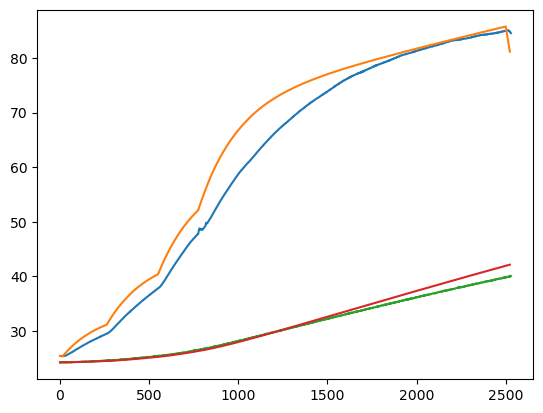

In [82]:
plot.plot(data.loc[:, "Time"], data.loc[:, "T_heater"], new_results.loc[:, "T_heater"])
plot.plot(data.loc[:, "Time"], data.loc[:, "T_liquid"], new_results.loc[:, "T_liquid"])
plot.show()

In [46]:
new_results

,Time,u,T_heater,T_liquid
0,0.0,0,25.36,24.2
1,0.0,0,25.36,24.2
2,1.0,0,25.35517,24.200427
3,2.0,0,25.350369,24.200853
4,3.0,0,25.345596,24.201279
...,...,...,...,...
2519,2525.0,0,65.597756,34.327156
2520,2526.0,0,65.400254,34.330121
2521,2527.0,0,65.203873,34.333048
2522,2528.0,0,65.008604,34.335937
